In [1]:
import numpy as np
import pandas as pd

import warnings
warnings.filterwarnings("ignore")

import calendar
from dateutil import easter

import spacy
from rapidfuzz import process, fuzz

import re
from collections import Counter

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [2]:
df = pd.read_csv("merged_kenya_tweets.csv", encoding='ISO-8859-1')
df.head(10)

,unnamed:_0,likes,retweets,total_replies,created_at,cleaned_text,label
0,0.0,39,2,0,2024-07-30 10:27:22+00:00,former ig japheth koome should be taken to icc...,neutral
1,1.0,0,0,0,2024-07-31 07:12:21+00:00,my views japheth koome should be charged prose...,neutral
2,2.0,5,5,0,2024-07-20 10:43:30+00:00,at this rate we might as well have ig japheth ...,neutral
3,3.0,593,248,114,2024-07-12 18:31:05+00:00,kenyas police chief japhet koome has resigned ...,neutral
4,4.0,6,4,0,2024-09-29 21:45:26+00:00,japheth koomes resignation has resulted in the...,neutral
5,5.0,0,0,0,2024-09-14 12:20:12+00:00,we are very funny creatures we have forgotten ...,offensive
6,6.0,5,0,1,2024-10-25 17:58:27+00:00,japheth koome alienda wapi,neutral
7,7.0,31,10,5,2024-07-15 08:15:13+00:00,azimio leader raila odinga has demanded the pr...,neutral
8,8.0,3,0,1,2024-08-31 14:09:31+00:00,attorney general dorcas oduor says her office ...,neutral
9,9.0,623,207,119,2024-07-14 19:16:09+00:00,jimmy wanjigi will be a guest speaker in x spa...,neutral


In [3]:
df.tail(10)

,unnamed:_0,likes,retweets,total_replies,created_at,cleaned_text,label
10961,NaN,15,8,1,2025-04-12 20:31:41+00:00,zimeshika kama dress ya millicent omanga,offensive
10962,NaN,8,5,1,2025-04-18 21:48:33+00:00,zimeshika kama pandi ya omanga,offensive
10963,NaN,14,7,1,2025-04-20 22:42:23+00:00,zimeshika kama thong ya millicent omanga,offensive
10964,NaN,6,6,1,2025-04-20 00:49:12+00:00,zimeshika kama thong ya omanga adi sioni simu ...,offensive
10965,NaN,41,25,0,2025-04-18 20:45:21+00:00,zimeshika kama thong ya omanga gadamn,offensive
10966,NaN,32,29,0,2025-04-11 19:01:31+00:00,zimeshika kuliko kata mafi ya omanga gadamn,offensive
10967,NaN,3,2,0,2025-04-13 02:01:10+00:00,zimeshika kuliko thong ya omanga,offensive
10968,NaN,0,0,0,2025-04-15 20:55:03+00:00,zinashika kama laana ya raila ama mkuu,offensive
10969,NaN,6,3,0,2024-10-09 02:22:10+00:00,zitamaliza salasya,neutral
10970,NaN,18,9,1,2025-04-19 22:28:15+00:00,zitashika kama panty ya millicent omanga,offensive


In [4]:
df.columns

Index(['unnamed:_0', 'likes', 'retweets', 'total_replies', 'created_at',
       'cleaned_text', 'label'],
      dtype='object')

In [5]:
df.shape

(10971, 7)

In [6]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10971 entries, 0 to 10970
Data columns (total 7 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   unnamed:_0     2251 non-null   float64
 1   likes          10971 non-null  int64  
 2   retweets       10971 non-null  int64  
 3   total_replies  10971 non-null  int64  
 4   created_at     10971 non-null  object 
 5   cleaned_text   10959 non-null  object 
 6   label          10971 non-null  object 
dtypes: float64(1), int64(3), object(3)
memory usage: 600.1+ KB


In [7]:
df.duplicated().sum()

780

In [8]:
df.isnull().sum()

unnamed:_0       8720
likes               0
retweets            0
total_replies       0
created_at          0
cleaned_text       12
label               0
dtype: int64

In [9]:
# Categorical summary only (object, category, etc.)
categorical_summary = df.describe(include=['object']).T
categorical_summary

,count,unique,top,freq
created_at,10971,8422,2025-04-21 12:16:23+00:00,6
cleaned_text,10959,8334,irredeemably incompetent amp corrupt pro max,24
label,10971,5,neutral,6953


In [10]:
# Numeric summary only
numeric_summary = df.describe(include=[float, int]).T
numeric_summary

,count,mean,std,min,25%,50%,75%,max
unnamed:_0,2251.0,1125.000000,649.952050,0.0,562.5,1125.0,1687.5,2250.0
likes,10971.0,943.430590,18116.995674,0.0,0.0,8.0,256.0,1060202.0
retweets,10971.0,205.710965,2907.186497,0.0,0.0,2.0,44.0,150446.0
total_replies,10971.0,62.092334,744.824541,0.0,0.0,1.0,16.0,63561.0


# 3. Data Preparation

## 3.1. Data Cleaning

In [11]:
# Convert to numeric columns
df['likes'] = pd.to_numeric(df['likes'], errors='coerce')
df['retweets'] = pd.to_numeric(df['retweets'], errors='coerce')
df['total_replies'] = pd.to_numeric(df['total_replies'], errors='coerce')

# Convert date column
df['created_at'] = pd.to_datetime(df['created_at'], errors='coerce')

In [12]:
# Convert to categorical columns
df['cleaned_text'] = df['cleaned_text'].astype('category')
df['label'] = df['label'].astype('category')

In [13]:
# Dropping unwanted column
df = df.drop(columns=['unnamed:_0'])

In [14]:
df = df.dropna()

In [15]:
# checking columns sfter dropping a column
df_columns = df.columns
print(df_columns)

Index(['likes', 'retweets', 'total_replies', 'created_at', 'cleaned_text',
       'label'],
      dtype='object')


In [16]:
# Dropping duplicates
df.drop_duplicates(inplace=True)

In [17]:
# Checking the first few rows of the dataset again
df.head(10)

,likes,retweets,total_replies,created_at,cleaned_text,label
0,39,2,0,2024-07-30 10:27:22+00:00,former ig japheth koome should be taken to icc...,neutral
1,0,0,0,2024-07-31 07:12:21+00:00,my views japheth koome should be charged prose...,neutral
2,5,5,0,2024-07-20 10:43:30+00:00,at this rate we might as well have ig japheth ...,neutral
3,593,248,114,2024-07-12 18:31:05+00:00,kenyas police chief japhet koome has resigned ...,neutral
4,6,4,0,2024-09-29 21:45:26+00:00,japheth koomes resignation has resulted in the...,neutral
5,0,0,0,2024-09-14 12:20:12+00:00,we are very funny creatures we have forgotten ...,offensive
6,5,0,1,2024-10-25 17:58:27+00:00,japheth koome alienda wapi,neutral
7,31,10,5,2024-07-15 08:15:13+00:00,azimio leader raila odinga has demanded the pr...,neutral
8,3,0,1,2024-08-31 14:09:31+00:00,attorney general dorcas oduor says her office ...,neutral
9,623,207,119,2024-07-14 19:16:09+00:00,jimmy wanjigi will be a guest speaker in x spa...,neutral


In [18]:
# Checking duplicates after dropping
df.duplicated().sum()

0

In [19]:
# checking shapes
df.shape

(8342, 6)

In [20]:
# Apply .lower() to every string cell in the DataFrame
df = df.applymap(lambda x: x.lower() if isinstance(x, str) else x)
df.head()

,likes,retweets,total_replies,created_at,cleaned_text,label
0,39,2,0,2024-07-30 10:27:22+00:00,former ig japheth koome should be taken to icc...,neutral
1,0,0,0,2024-07-31 07:12:21+00:00,my views japheth koome should be charged prose...,neutral
2,5,5,0,2024-07-20 10:43:30+00:00,at this rate we might as well have ig japheth ...,neutral
3,593,248,114,2024-07-12 18:31:05+00:00,kenyas police chief japhet koome has resigned ...,neutral
4,6,4,0,2024-09-29 21:45:26+00:00,japheth koomes resignation has resulted in the...,neutral


In [21]:
df['label'].value_counts()

label
neutral      4914
hate         1840
offensive    1588
Name: count, dtype: int64

## 3.2.  Feature Engineering

Feature engineering is a critical step in preparing the dataset for analysis and modeling. It involves creating new features that better represent the underlying patterns in the data. Below are the engineered features and the reasoning behind their inclusion:

### Columns Used for Feature Engineering

- **likes**, **retweets**, **total_replies**
  - These three metrics reflect user engagement with a tweet. Individually, they are important, but combined, they can offer a more comprehensive view.

- **cleaned_text**
  - The cleaned tweet content is used to extract linguistic features like length, word count, hashtags, and mentions, which help understand the structure and purpose of a tweet.

- **created_at**
  - This datetime field is used to derive time-based patterns, such as when a politician is trending or how tweet activity varies by season, hour, or weekday.

---

### New Features Created

- **engagement_score** = likes + retweets + total_replies  
  → A unified metric to measure tweet popularity or user response.

- **tweet_length**  
  → Total number of characters in a tweet. Longer tweets may carry more detail or stronger sentiment.

- **word_count**  
  → Number of words in a tweet. Helps analyze verbosity or messaging style.

- **hour**, **day**, **month**, **year**, **day_of_week**, **season**  
  → Helps analyze temporal trends in tweet activity and engagement, including political events or public sentiment surges.

---

These engineered features help improve the interpretability of the dataset and enhance the performance.


### 1. Engagement Score (likes, retweets, and replies)

In [22]:
df['engagement_score'] = df['likes'] + df['retweets'] + df['total_replies']

### 2. Tweet Length (number of characters)

In [23]:
df['tweet_length'] = df['cleaned_text'].apply(len)
df['tweet_length'].head(5)

0     74
1    120
2    104
3    246
4    273
Name: tweet_length, dtype: int64

### 3. Word Count

In [24]:
df['word_count'] = df['cleaned_text'].apply(lambda x: len(str(x).split()))
df.head(10)

,likes,retweets,total_replies,created_at,cleaned_text,label,engagement_score,tweet_length,word_count
0,39,2,0,2024-07-30 10:27:22+00:00,former ig japheth koome should be taken to icc...,neutral,41,74,13
1,0,0,0,2024-07-31 07:12:21+00:00,my views japheth koome should be charged prose...,neutral,0,120,18
2,5,5,0,2024-07-20 10:43:30+00:00,at this rate we might as well have ig japheth ...,neutral,10,104,19
3,593,248,114,2024-07-12 18:31:05+00:00,kenyas police chief japhet koome has resigned ...,neutral,955,246,37
4,6,4,0,2024-09-29 21:45:26+00:00,japheth koomes resignation has resulted in the...,neutral,10,273,43
5,0,0,0,2024-09-14 12:20:12+00:00,we are very funny creatures we have forgotten ...,offensive,0,239,39
6,5,0,1,2024-10-25 17:58:27+00:00,japheth koome alienda wapi,neutral,6,26,4
7,31,10,5,2024-07-15 08:15:13+00:00,azimio leader raila odinga has demanded the pr...,neutral,46,236,34
8,3,0,1,2024-08-31 14:09:31+00:00,attorney general dorcas oduor says her office ...,neutral,4,271,41
9,623,207,119,2024-07-14 19:16:09+00:00,jimmy wanjigi will be a guest speaker in x spa...,neutral,949,272,48


### 4. Extract Named Entities of Type PERSON (e.g., politicians)

In [25]:
# Ensure cleaned_text is treated as regular string (not categorical)
df['cleaned_text'] = df['cleaned_text'].astype(str)

# 1. Define canonical names and their known aliases/nicknames (global dictionary)
alias_to_canonical = {
    'william ruto': 'William Ruto',
    'ruto': 'William Ruto',
    'zakayo': 'William Ruto',
    'el chapo': 'William Ruto',
    'raila odinga': 'Raila Odinga',
    'raila': 'Raila Odinga',
    'baba': 'Raila Odinga',
    'tinga': 'Raila Odinga',
    'martha karua': 'Martha Karua',
    'iron lady': 'Martha Karua',
    'rigathi gachagua': 'Rigathi Gachagua',
    'riggy g': 'Rigathi Gachagua',
    'riggy': 'Rigathi Gachagua',
    'musalia mudavadi': 'Musalia Mudavadi',
    'mudavadi': 'Musalia Mudavadi',
    'prime cs': 'Musalia Mudavadi',
    'kithure kindiki': 'Kithure Kindiki',
    'kindiki': 'Kithure Kindiki',
    'aden duale': 'Aden Duale',
    'duale': 'Aden Duale',
    'martha koome': 'Martha Koome',
    'fred matiangi': 'Fred Matiang’i',
    'matiangi': 'Fred Matiang’i',
    'johnson sakaja': 'Johnson Sakaja',
    'sakaja': 'Johnson Sakaja',
    'noordin haji': 'Noordin Haji',
    'japheth koome': 'Japheth Koome',
    'rachel ruto': 'Rachel Ruto',
    'mama rachel': 'Rachel Ruto',
    'oscar sudi': 'Oscar Sudi',
    'sudi': 'Oscar Sudi',
    'moses kuria': 'Moses Kuria',
    'kalonzo musyoka': 'Kalonzo Musyoka',
    'musyoka': 'Kalonzo Musyoka',
    'gloria orwoba': 'Gloria Orwoba',
    'john kiarie': 'John Kiarie',
    'didmus barasa': 'Didmus Barasa',
    'betty maina': 'Betty Maina',
    'alice nganga': 'Alice Nganga',
    'karambu': 'Martha Karua',
}

def extract_politicians(text):
    found = set()
    lower_text = text.lower()
    for alias, canonical in alias_to_canonical.items():
        if re.search(r'\b' + re.escape(alias) + r'\b', lower_text):
            found.add(canonical)
    return list(found) if found else None

# Apply extraction
df['politicians'] = df['cleaned_text'].apply(extract_politicians)


# Check the results
print(df[['cleaned_text', 'politicians']].head())

                                        cleaned_text      politicians
0  former ig japheth koome should be taken to icc...  [Japheth Koome]
1  my views japheth koome should be charged prose...  [Japheth Koome]
2  at this rate we might as well have ig japheth ...  [Japheth Koome]
3  kenyas police chief japhet koome has resigned ...             None
4  japheth koomes resignation has resulted in the...             None


### 5. Extract Time Features

In [26]:
def extract_time_features(df, datetime_col='created_at'):
    """
    Extracts time-based features from a datetime column.
    Adds: year, month, day, hour, day_of_week
    Skips rows where datetime_col is missing.
    """
    # Ensure datetime format
    df[datetime_col] = pd.to_datetime(df[datetime_col], errors='coerce')

    # Only apply on non-null datetime values
    mask = df[datetime_col].notnull()

    df.loc[mask, 'year'] = df.loc[mask, datetime_col].dt.year
    df.loc[mask, 'month'] = df.loc[mask, datetime_col].dt.month
    df.loc[mask, 'day'] = df.loc[mask, datetime_col].dt.day
    df.loc[mask, 'hour'] = df.loc[mask, datetime_col].dt.hour
    df.loc[mask, 'day_of_week'] = df.loc[mask, datetime_col].dt.day_name()

    return df

df = extract_time_features(df)  # This ensures 'year' and other time features exist

#### 5.1. Define Fixed Holidays and other holidays

In [27]:
def add_named_holidays(df):
    fixed_holidays = {
        '01-01': "New Year's Day",
        '05-01': "Labour Day",
        '06-01': "Madaraka Day",
        '10-20': "Mashujaa Day",
        '12-12': "Jamhuri Day",
        '12-25': "Christmas Day",
        '12-26': "Boxing Day"
    }

    # Eid dates
    eid_dates = {
        2015: {'Eid al-Fitr': '07-17', 'Eid al-Adha': '09-24'},
        2016: {'Eid al-Fitr': '07-06', 'Eid al-Adha': '09-12'},
        2017: {'Eid al-Fitr': '06-25', 'Eid al-Adha': '09-01'},
        2018: {'Eid al-Fitr': '06-15', 'Eid al-Adha': '08-21'},
        2019: {'Eid al-Fitr': '06-04', 'Eid al-Adha': '08-11'},
        2020: {'Eid al-Fitr': '05-24', 'Eid al-Adha': '07-31'},
        2021: {'Eid al-Fitr': '05-13', 'Eid al-Adha': '07-20'},
        2022: {'Eid al-Fitr': '05-02', 'Eid al-Adha': '07-09'},
        2023: {'Eid al-Fitr': '04-21', 'Eid al-Adha': '06-28'},
        2024: {'Eid al-Fitr': '04-10', 'Eid al-Adha': '06-17'},
        2025: {'Eid al-Fitr': '03-30', 'Eid al-Adha': '06-06'},
    }

    # Easter dates
    easter_dates = {
        2015: '04-05',
        2016: '03-27',
        2017: '04-16',
        2018: '04-01',
        2019: '04-21',
        2020: '04-12',
        2021: '04-04',
        2022: '04-17',
        2023: '04-09',
        2024: '03-31',
        2025: '04-20',
    }

    df['holiday_name'] = None

    for idx, row in df.iterrows():
        if pd.isna(row['year']):
            continue  # Skip rows without year

        month_day = row['created_at'].strftime('%m-%d')
        year = int(row['year'])

        # Fixed holidays
        if month_day in fixed_holidays:
            df.at[idx, 'holiday_name'] = fixed_holidays[month_day]

        # Easter-based holidays
        if year in easter_dates:
            easter_day = pd.to_datetime(f"{year}-{easter_dates[year]}")
            if month_day == (easter_day - pd.Timedelta(days=2)).strftime('%m-%d'):
                df.at[idx, 'holiday_name'] = "Good Friday"
            elif month_day == (easter_day + pd.Timedelta(days=1)).strftime('%m-%d'):
                df.at[idx, 'holiday_name'] = "Easter Monday"

        # Eid holidays
        if year in eid_dates:
            for name, eid_md in eid_dates[year].items():
                if month_day == eid_md:
                    df.at[idx, 'holiday_name'] = name

    return df
df = add_named_holidays(df)

In [28]:
df['engagement_score'].value_counts()

engagement_score
0       1263
1        512
2        365
3        246
4        227
        ... 
1008       1
488        1
2571       1
4562       1
1946       1
Name: count, Length: 1888, dtype: int64

In [29]:
print(df.columns)

Index(['likes', 'retweets', 'total_replies', 'created_at', 'cleaned_text',
       'label', 'engagement_score', 'tweet_length', 'word_count',
       'politicians', 'year', 'month', 'day', 'hour', 'day_of_week',
       'holiday_name'],
      dtype='object')


In [30]:
df = add_named_holidays(df)
df['holiday_name'].value_counts()

holiday_name
Easter Monday     450
Good Friday       268
Christmas Day      63
Boxing Day         60
Eid al-Fitr        29
Eid al-Adha        10
Mashujaa Day        9
Labour Day          9
Madaraka Day        8
Jamhuri Day         7
New Year's Day      6
Name: count, dtype: int64

In [31]:
#df['holiday_name'] = df['holiday_name'].fillna('not_holiday')
df['holiday_name'] = df['holiday_name'].replace({None: 'not_holiday'}).fillna('not_holiday')

In [32]:
df.shape

(8342, 16)

### Standardize the entity names without dropping

In [33]:
# Prepare and clean entity strings
entities_series = df['politicians'].fillna('').astype(str).str.lower().str.split(',')
all_entities = [name.strip() for sublist in entities_series for name in sublist if name.strip()]

# Build a frequency counter to prioritize common names
from collections import Counter
entity_counts = Counter(all_entities)

# Get unique names
unique_entities = list(entity_counts.keys())

# Map similar names to a representative (canonical) name
canonical_map = {}
used = set()

for name in unique_entities:
    if name in used:
        continue
    matches = process.extract(
        name, unique_entities, scorer=fuzz.token_sort_ratio, limit=None
    )
    # Group names with similarity > 90
    similar_names = [match for match, score, _ in matches if score > 90]
    for sim in similar_names:
        canonical_map[sim] = name
        used.add(sim)

# Apply mapping to original DataFrame
def standardize_entities(entity_list):
    # Handle missing or invalid entries
    if entity_list is None or isinstance(entity_list, float) and np.isnan(entity_list):
        return ''
    if isinstance(entity_list, str):
        try:
            entity_list = ast.literal_eval(entity_list)
        except:
            return entity_list  # return the string if not a list-like string

    if not isinstance(entity_list, list):
        return ''

    std_names = [canonical_map.get(name.lower(), name) for name in entity_list]
    return ', '.join(sorted(set(std_names)))

df['politicians_standardized'] = df['politicians'].apply(standardize_entities)

In [34]:
# Explode comma-separated names into individual rows
df['politicians_standardized'] = df['politicians_standardized'].astype(str)
df = df.assign(
    clean_names = df['politicians_standardized'].str.split(',')
).explode('clean_names')

# Remove whitespace and drop empty or null values
df['clean_names'] = df['clean_names'].str.strip()

df = df.explode('clean_names')

# Strip whitespace, replace empty with NaN, then fill with 'unknown'
df['clean_names'] = df['clean_names'].str.strip()
df['clean_names'] = df['clean_names'].replace('', np.nan)
df['clean_names'] = df['clean_names'].fillna('unknown')

# (Optional) Reset index if needed
df.reset_index(drop=True, inplace=True)

In [35]:
df['clean_names'].head(10)

0      Japheth Koome
1      Japheth Koome
2      Japheth Koome
3            unknown
4            unknown
5      Japheth Koome
6      Japheth Koome
7      Japheth Koome
8    Kithure Kindiki
9       Raila Odinga
Name: clean_names, dtype: object

In [36]:
df.columns

Index(['likes', 'retweets', 'total_replies', 'created_at', 'cleaned_text',
       'label', 'engagement_score', 'tweet_length', 'word_count',
       'politicians', 'year', 'month', 'day', 'hour', 'day_of_week',
       'holiday_name', 'politicians_standardized', 'clean_names'],
      dtype='object')

In [37]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9276 entries, 0 to 9275
Data columns (total 18 columns):
 #   Column                    Non-Null Count  Dtype              
---  ------                    --------------  -----              
 0   likes                     9276 non-null   int64              
 1   retweets                  9276 non-null   int64              
 2   total_replies             9276 non-null   int64              
 3   created_at                9276 non-null   datetime64[ns, UTC]
 4   cleaned_text              9276 non-null   object             
 5   label                     9276 non-null   object             
 6   engagement_score          9276 non-null   int64              
 7   tweet_length              9276 non-null   int64              
 8   word_count                9276 non-null   int64              
 9   politicians               4119 non-null   object             
 10  year                      9276 non-null   float64            
 11  month            

In [38]:
df.shape

(9276, 18)

### 5. Outlier detection

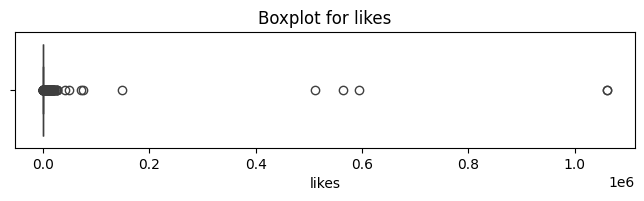

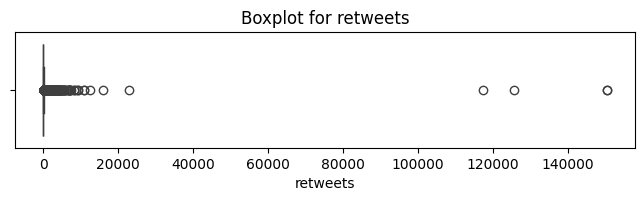

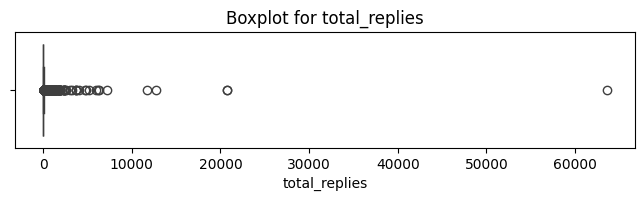

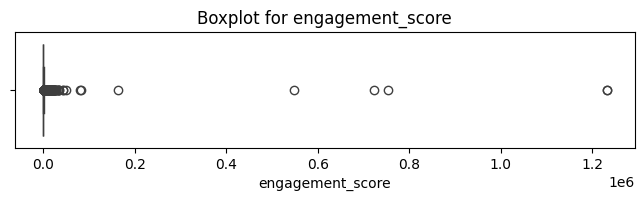

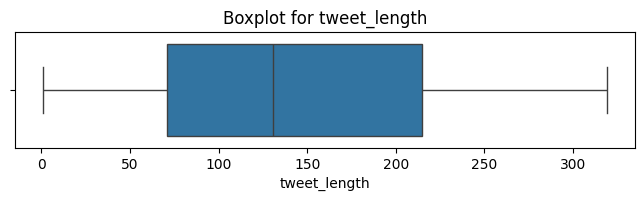

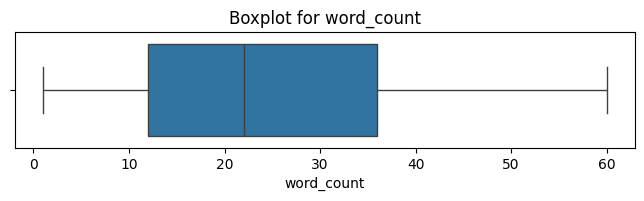

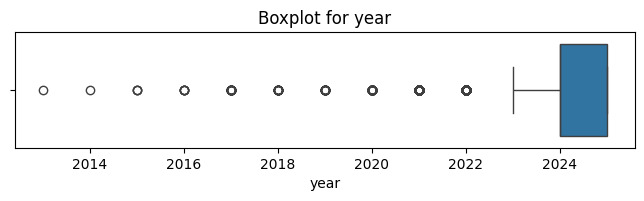

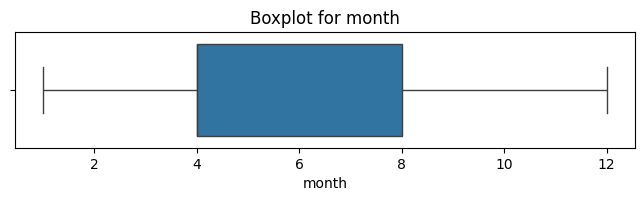

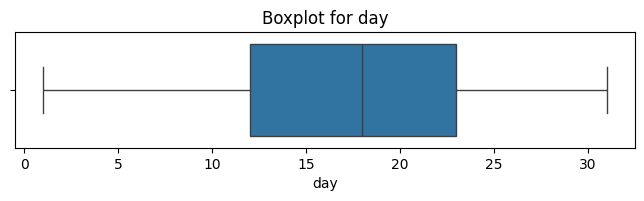

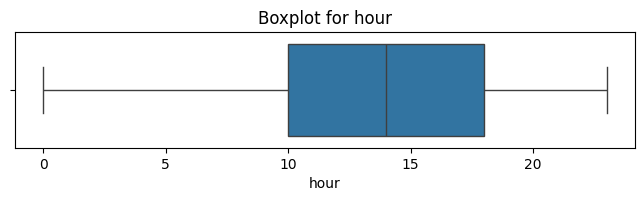

In [39]:
# To remove duplicates
df = df.reset_index(drop=True)

# Select only numeric columns
numeric_cols = ['likes', 'retweets', 'total_replies', 'engagement_score', 
                'tweet_length', 'word_count', 'year', 'month', 'day', 'hour']

for col in numeric_cols:
    plt.figure(figsize=(8, 1.5))
    sns.boxplot(x=df[col])
    plt.title(f"Boxplot for {col}")
    plt.show()

In [40]:
# Make sure labels are lowercase for mapping consistency
df['label'] = df['label'].str.lower()

# Map 3-class to binary
binary_map = {
    'hate': 'Hate',
    'offensive': 'Hate',
    'neutral': 'Not_Hate'
}

df['label'] = df['label'].map(binary_map)

# Save the new binary-labeled dataset
df.to_csv("labeled_kenya_tweets_binary.csv", index=False)

In [41]:
df.isnull().sum()

likes                          0
retweets                       0
total_replies                  0
created_at                     0
cleaned_text                   0
label                          0
engagement_score               0
tweet_length                   0
word_count                     0
politicians                 5157
year                           0
month                          0
day                            0
hour                           0
day_of_week                    0
holiday_name                   0
politicians_standardized       0
clean_names                    0
dtype: int64

In [42]:
# Dropping unwanted column
df = df.drop(columns=['politicians'])

In [43]:
df.isnull().sum()

likes                       0
retweets                    0
total_replies               0
created_at                  0
cleaned_text                0
label                       0
engagement_score            0
tweet_length                0
word_count                  0
year                        0
month                       0
day                         0
hour                        0
day_of_week                 0
holiday_name                0
politicians_standardized    0
clean_names                 0
dtype: int64

## 3.3. Exploratory Data Analysis(EDA)

### 3.3.1 Univariate Analysis
Univariate Analysis involves analyzing the relationship of single variable.

#### Distribution of Labels

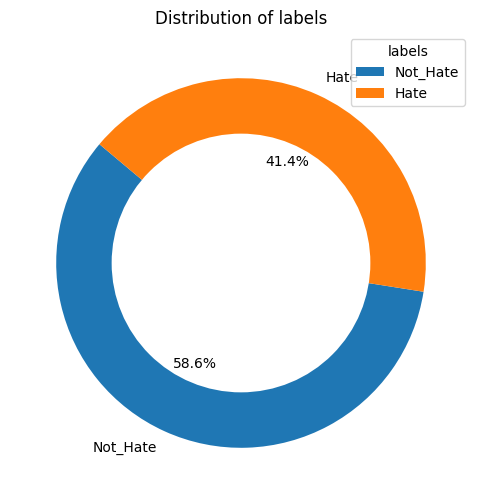

In [44]:
# count of the labels
label_count = df['label'].value_counts()

# create a piplot to show thw distribution
plt.figure(figsize=(8,6))
plt.pie(label_count, labels=label_count.index, autopct='%1.1f%%', startangle=140)

# create a blank circle at the centre
centre_circle = plt.Circle((0,0),0.70,fc='white')
fig = plt.gcf()
fig.gca().add_artist(centre_circle)

# customize the plot
plt.title("Distribution of labels")
plt.legend(title="labels", loc="upper right")
plt.show()

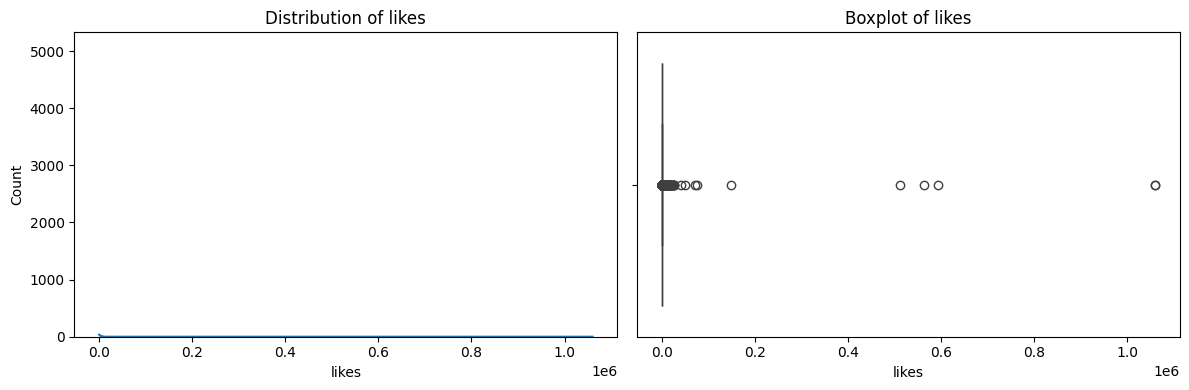

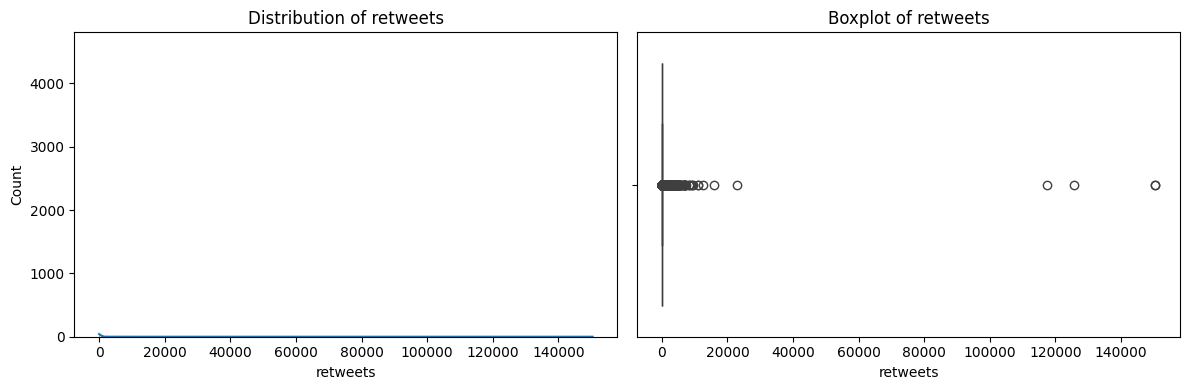

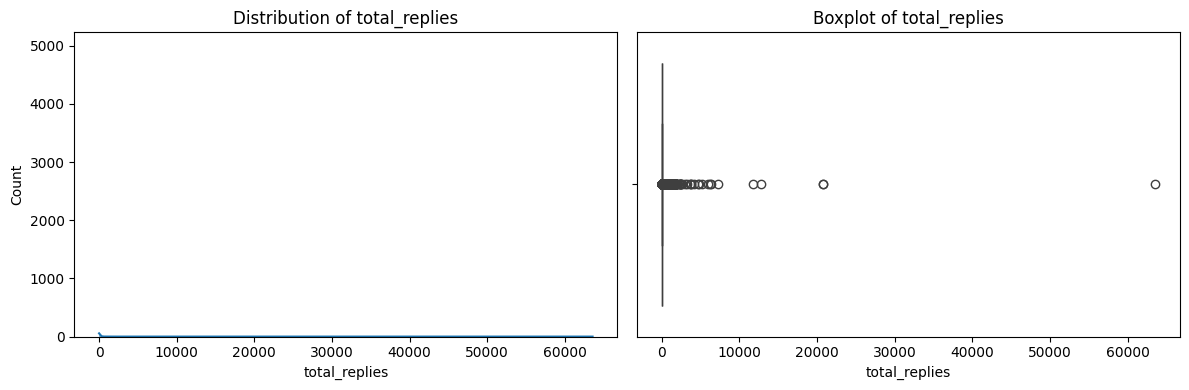

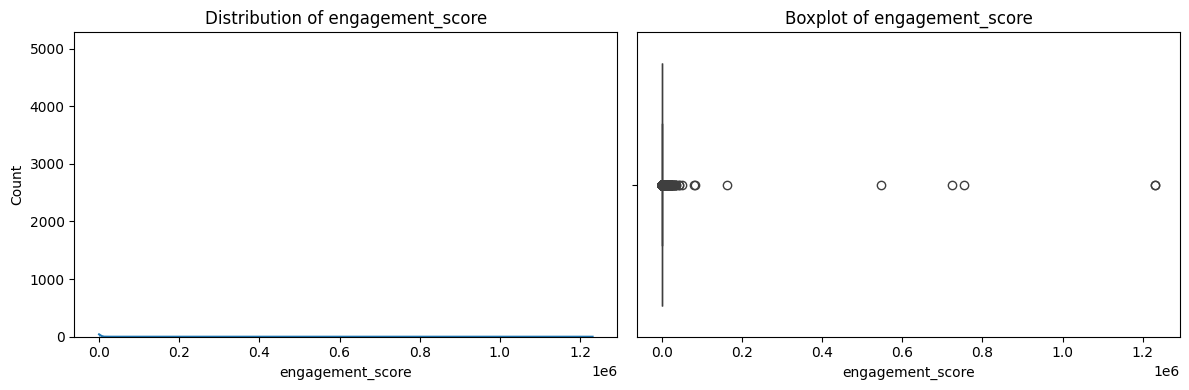

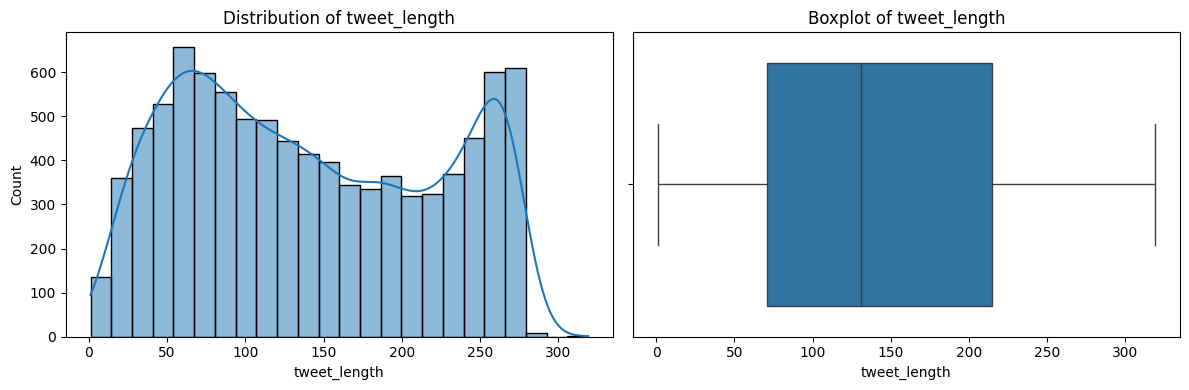

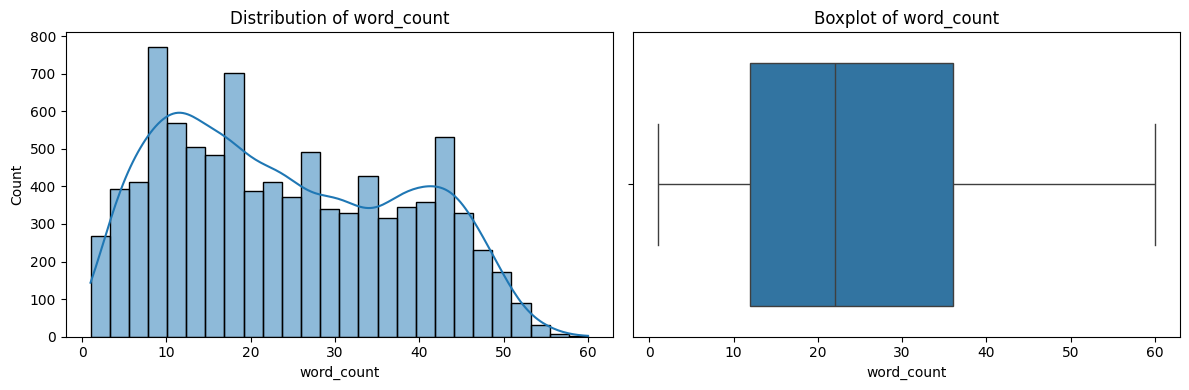

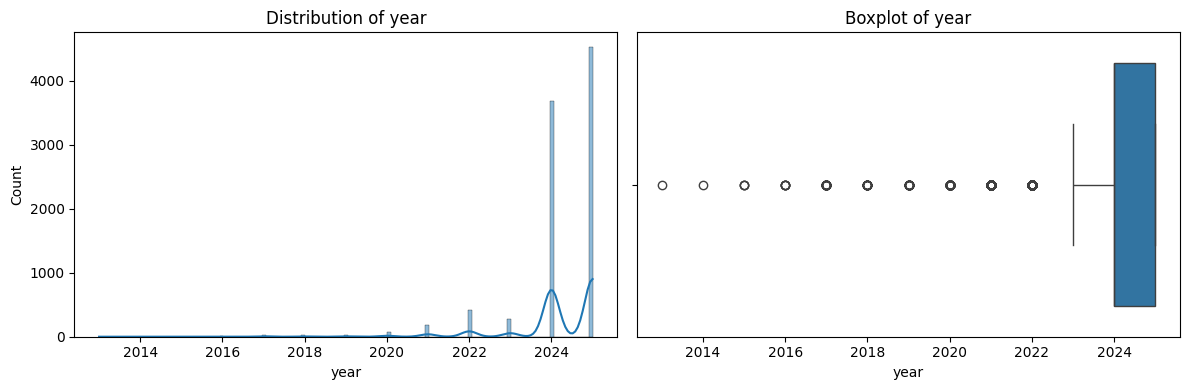

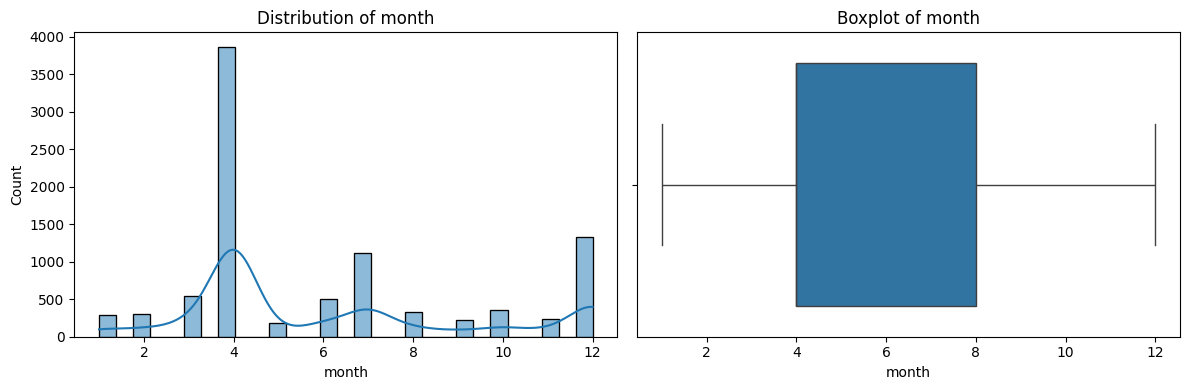

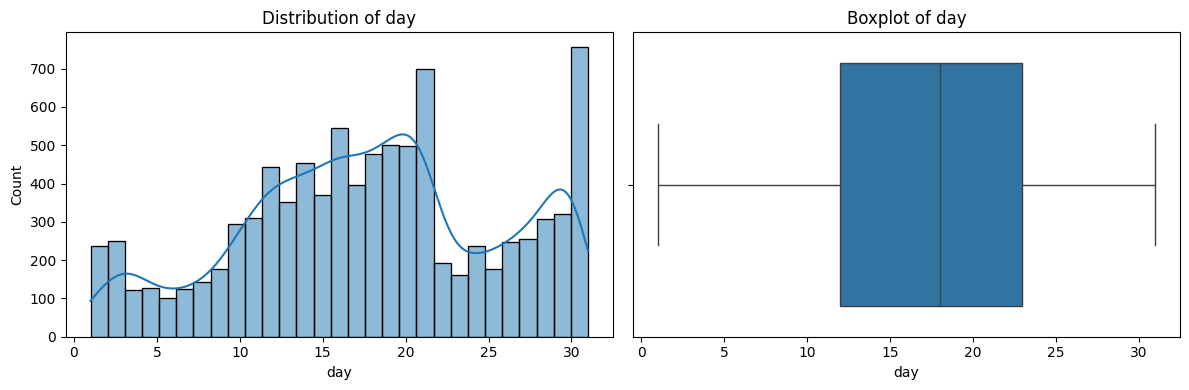

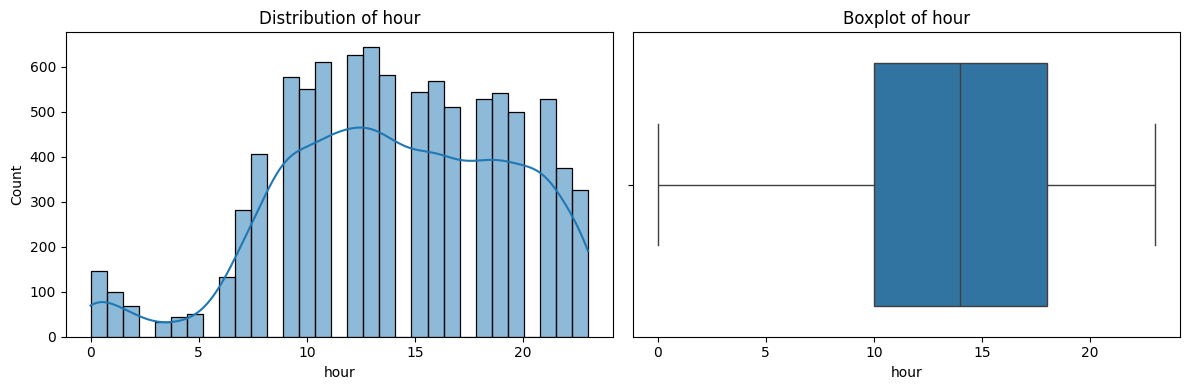

In [45]:
# Numerical Features
numeric_cols = ['likes', 'retweets', 'total_replies', 'engagement_score',
                'tweet_length', 'word_count', 'year', 'month', 'day', 'hour']

# Plot distributions and boxplots
for col in numeric_cols:
    plt.figure(figsize=(12, 4))

    plt.subplot(1, 2, 1)
    sns.histplot(df[col].dropna(), kde=True)
    plt.title(f'Distribution of {col}')

    plt.subplot(1, 2, 2)
    sns.boxplot(x=df[col].dropna(), orient='h')
    plt.title(f'Boxplot of {col}')

    plt.tight_layout()
    plt.show()

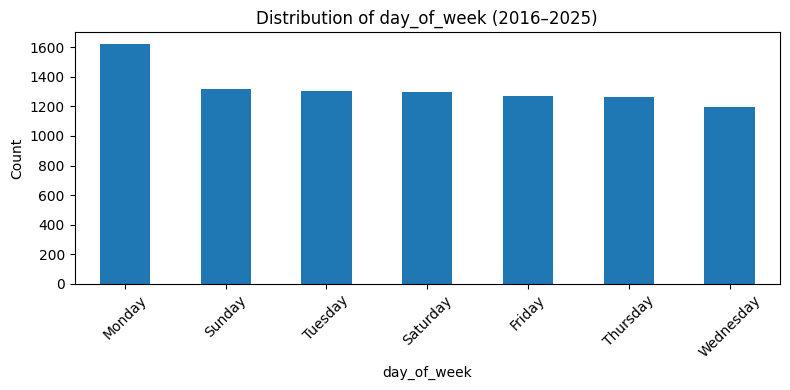

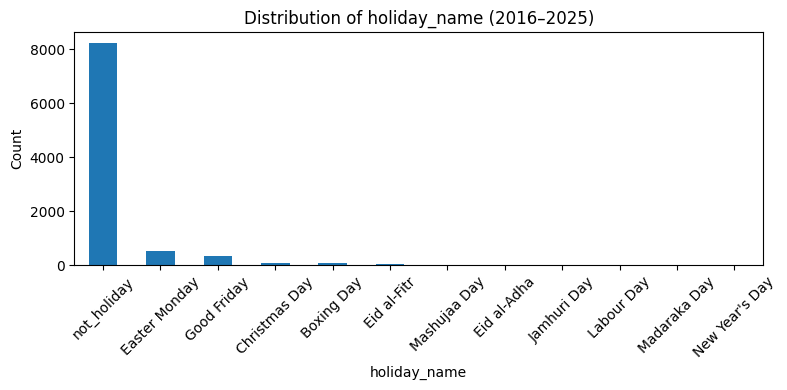

In [46]:
# Filter DataFrame to only include years between 2015 and 2025
df_filtered = df[(df['year'] >= 2016) & (df['year'] <= 2025)]

# Categorical Features 
categorical_cols = ['day_of_week', 'holiday_name']

for col in categorical_cols:
    plt.figure(figsize=(8, 4))
    df[col].value_counts(dropna=False).plot(kind='bar')
    plt.title(f'Distribution of {col} (2016–2025)')
    plt.xlabel(col)
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#### Time-Based Tweet Patterns
Explore tweets by hour, day of week, and month:

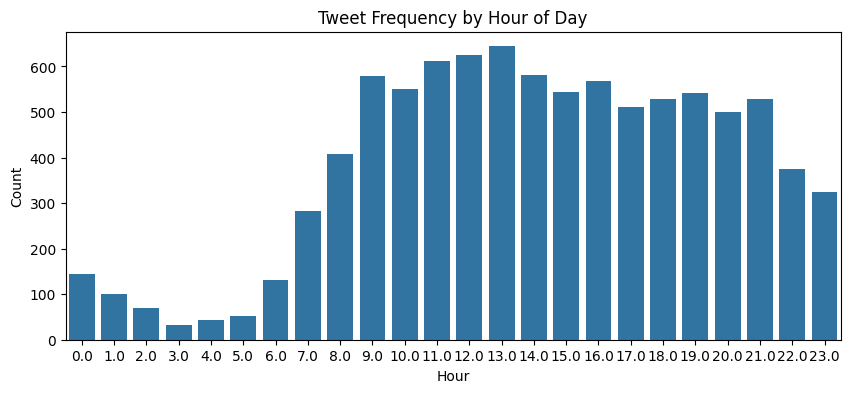

In [47]:
# Hour of Day
plt.figure(figsize=(10, 4))
sns.countplot(x='hour', data=df)
plt.title("Tweet Frequency by Hour of Day")
plt.xlabel("Hour")
plt.ylabel("Count")
plt.show()

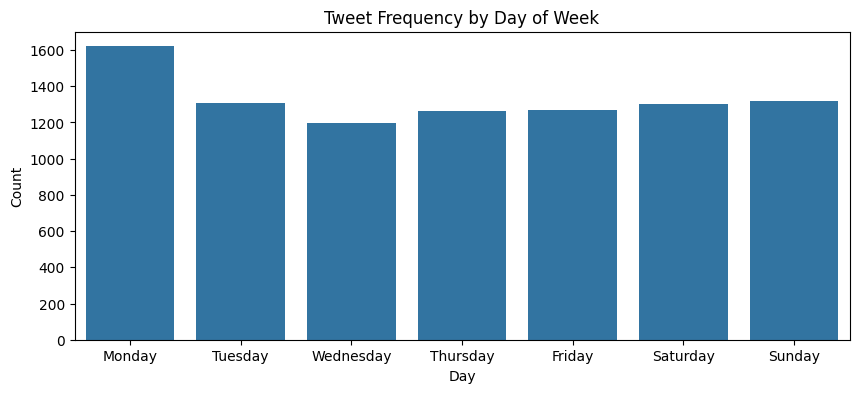

In [48]:
# Day of Week
plt.figure(figsize=(10, 4))
order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
sns.countplot(x='day_of_week', data=df, order=order)
plt.title("Tweet Frequency by Day of Week")
plt.xlabel("Day")
plt.ylabel("Count")
plt.show()

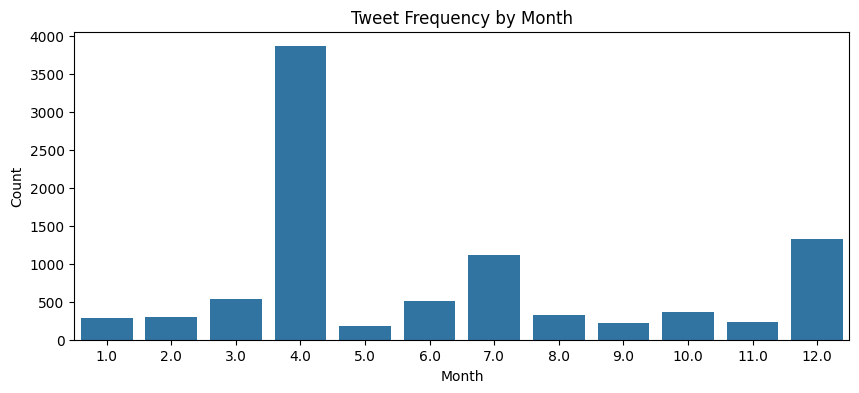

In [49]:
# Month
plt.figure(figsize=(10, 4))
sns.countplot(x='month', data=df)
plt.title("Tweet Frequency by Month")
plt.xlabel("Month")
plt.ylabel("Count")
plt.show()

In [50]:
#print("\n--- Skewness & Kurtosis ---")
for col in numeric_cols:
    if df[col].dtype != 'object':
        skew = df[col].skew()
        kurt = df[col].kurtosis()
        print(f"{col}: Skewness = {skew:.2f}, Kurtosis = {kurt:.2f}")

likes: Skewness = 47.97, Kurtosis = 2484.70
retweets: Skewness = 45.37, Kurtosis = 2178.57
total_replies: Skewness = 62.14, Kurtosis = 4721.48
engagement_score: Skewness = 47.25, Kurtosis = 2400.19
tweet_length: Skewness = 0.19, Kurtosis = -1.27
word_count: Skewness = 0.27, Kurtosis = -1.10
year: Skewness = -2.90, Kurtosis = 12.14
month: Skewness = 0.71, Kurtosis = -0.74
day: Skewness = -0.16, Kurtosis = -0.66
hour: Skewness = -0.35, Kurtosis = -0.30


#### Holiday Tweet Analysis
Check how many tweets fall on holidays vs regular days:

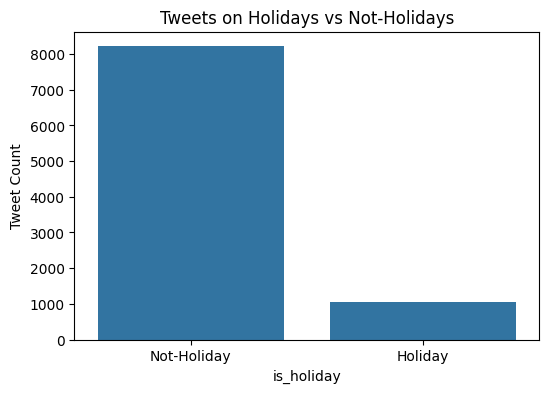

In [51]:
df['is_holiday'] = df['holiday_name'] != 'not_holiday'

plt.figure(figsize=(6, 4))
sns.countplot(x='is_holiday', data=df)
plt.title("Tweets on Holidays vs Not-Holidays")
plt.xticks([0, 1], ['Not-Holiday', 'Holiday'])
plt.ylabel("Tweet Count")
plt.show()

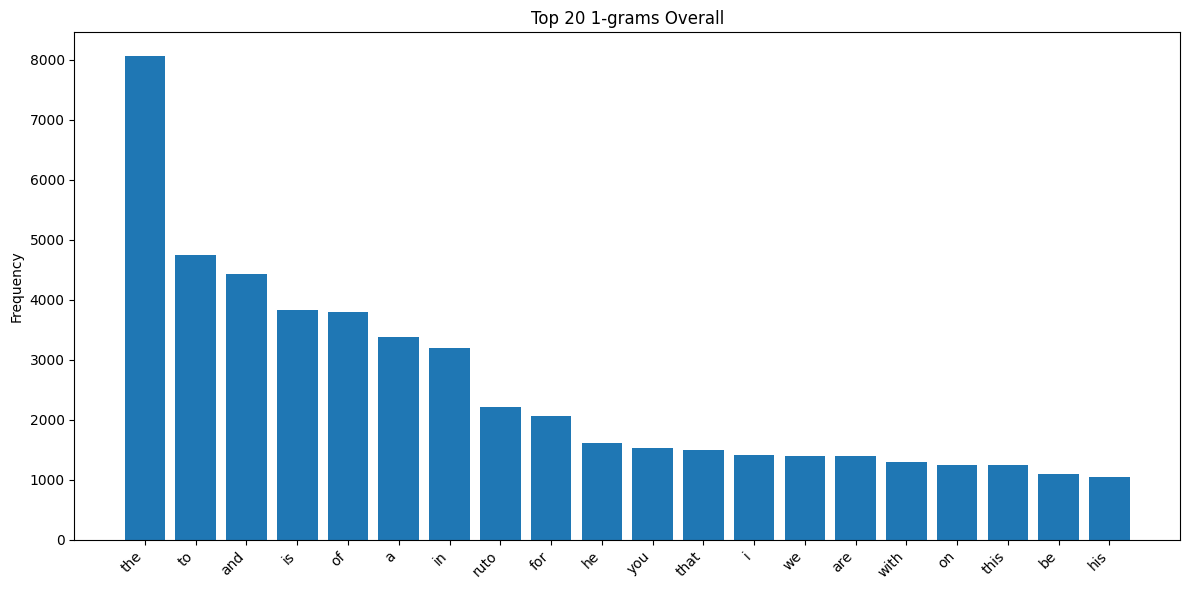

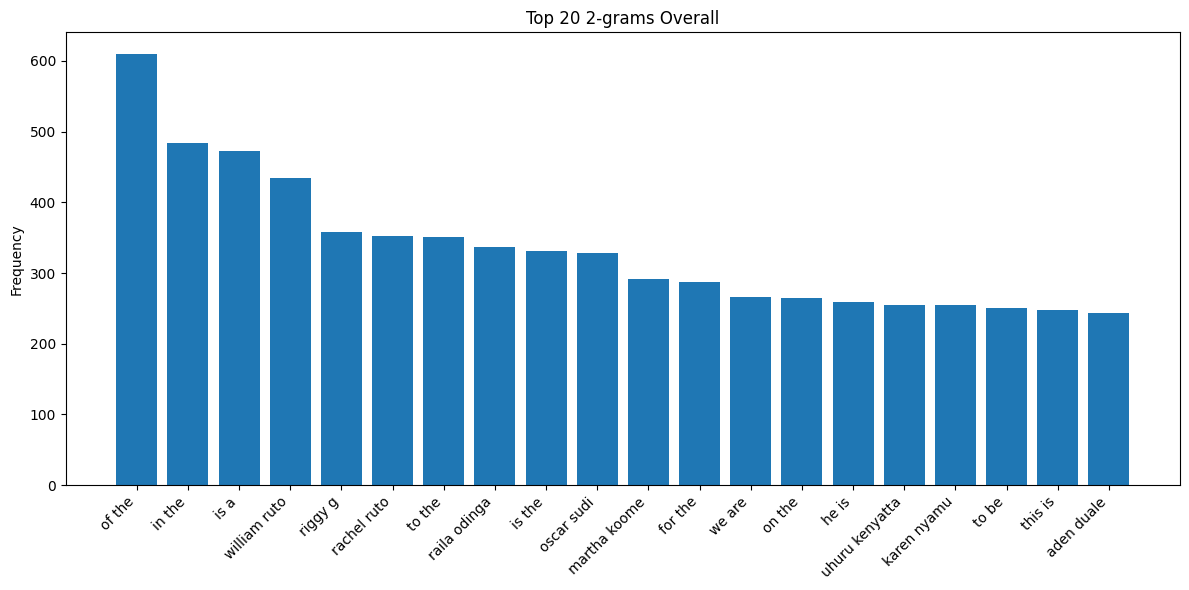

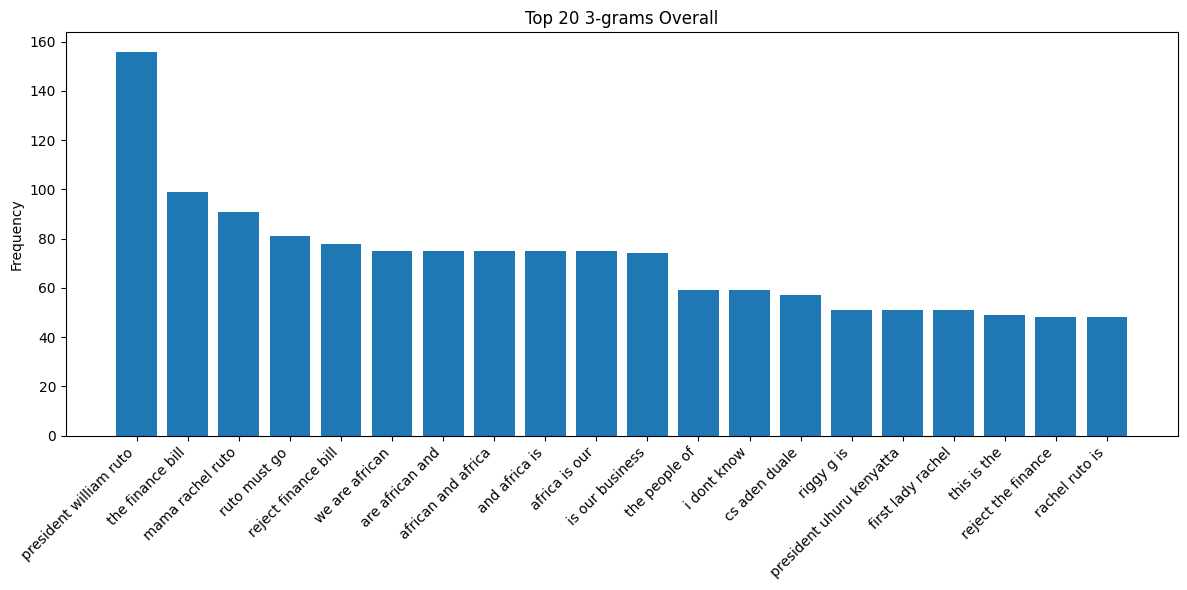

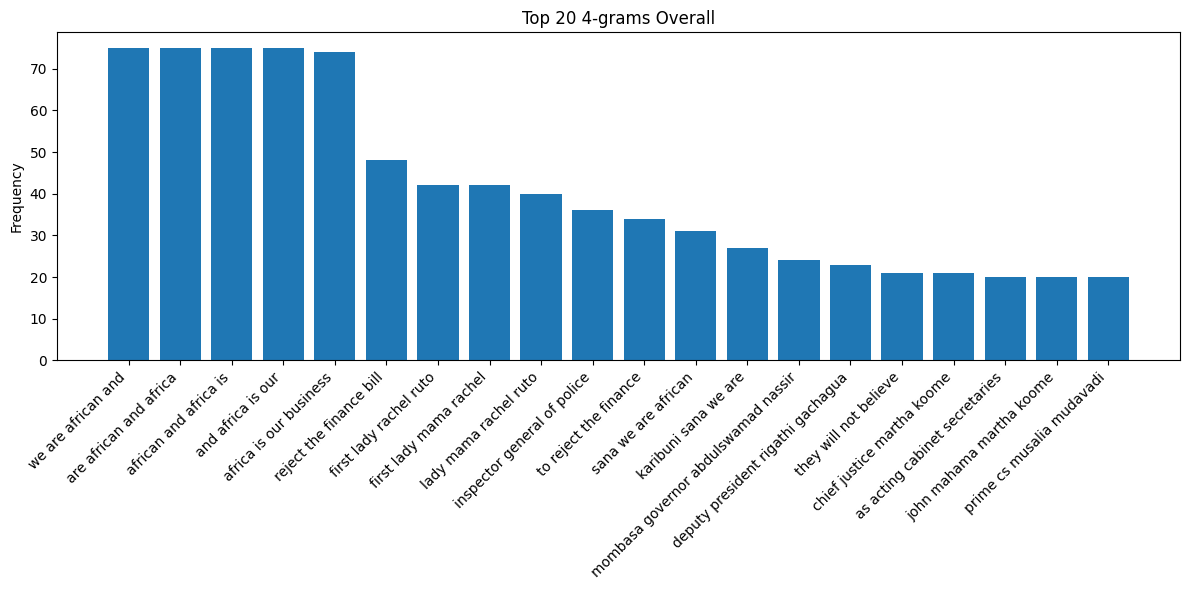

In [52]:
from nltk import ngrams

# Function to get top n-grams
def get_top_ngrams(text_series, n=1, top_k=10):
    counter = Counter()
    for text in text_series:
        tokens = text.split()
        counter.update(ngrams(tokens, n))
    return counter.most_common(top_k)

N = 20  # Defining the desired number of top N-grams

# Univariate analysis for N-grams
ngram_orders = [1, 2, 3, 4]  # Analyze 1-grams, 2-grams, and 3-grams

for n in ngram_orders:
    top_ngrams_overall = get_top_ngrams(df['cleaned_text'], n=n, top_k=N)
    grams = [' '.join(g) for g, _ in top_ngrams_overall]
    counts = [cnt for _, cnt in top_ngrams_overall]

    plt.figure(figsize=(12, 6))
    plt.bar(grams, counts)
    plt.title(f"Top {N} {n}-grams Overall")
    plt.ylabel('Frequency')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()

# N-Gram Frequency Analysis

This section presents an overview of the top N-gram frequencies (from unigrams to 4-grams) extracted from a textual dataset, highlighting key themes and entities.

## Top 20 1-Grams (Unigrams)

**Observations:**
- The most frequent unigrams are common English stopwords such as **"the"**, **"to"**, **"and"**, **"is"**, and **"of"**.
- Among named entities, **"ruto"** appears with notable frequency, suggesting a high presence of Kenya's President **William Ruto** in the text.
- Other pronouns like **"he"**, **"you"**, **"we"**, and **"I"** also rank highly, indicating a conversational or narrative-heavy dataset.

---

## Top 20 2-Grams (Bigrams)

**Observations:**
- Frequent bigrams include expected phrase structures like **"of the"**, **"in the"**, and **"is a"**.
- Key named entities become clearer: **"william ruto"**, **"riggy g"**, **"rachel ruto"**, **"raila odinga"**, and **"martha koome"**—all prominent figures in Kenyan politics.
- Shows a strong political discourse embedded in the dataset.

---

## Top 20 3-Grams (Trigrams)

**Observations:**
- Named trigrams such as **"president william ruto"**, **"mama rachel ruto"**, and **"cs aden duale"** confirm the political orientation of the dataset.
- Political sentiment and action-oriented phrases like **"ruto must go"**, **"reject finance bill"**, and **"is our business"** begin to surface.
- This level offers insight into not just entities but their roles or associated events.

---

## Top 20 4-Grams

**Observations:**
- Clear, coherent phrases emerge such as:
  - **"we are african and"**, **"africa is our business"**
  - **"reject the finance bill"**
  - **"first lady rachel ruto"**, **"chief justice martha koome"**
- Highlights both socio-political narratives and government-related discourse.
- Phrases suggest emphasis on **identity, governance, and resistance** themes.

---

## Summary

This N-gram analysis reveals a **politically charged dataset** centered on Kenyan political figures, governance, and current socio-political themes. The higher-order N-grams (3- and 4-grams) provide the clearest insight into **named entities**, **political discourse**, and **sentiment** (e.g., protest language, national identity assertions).

### 3.3.2 Bivariate Analysis
Bivariate Analysis involves analyzing the relationship between two variables.

### 1. Tweet Volume by Engagement

In [53]:
# Convert 'created_at' to datetime
df['created_at'] = pd.to_datetime(df['created_at'])

# Group data by date
df['date'] = df['created_at'].dt.date

# Calculate Tweet Volume and Engagement
tweet_volume = df.groupby('date')['cleaned_text'].count()
engagement = df.groupby('date')['likes'].sum() + df.groupby('date')['retweets'].sum() + df.groupby('date')['total_replies'].sum()

### 3.3.2 Engagement Score vs Hour / Day / Month

See when tweets get the most traction.

#### 1. Engagement Score vs Hour of Day

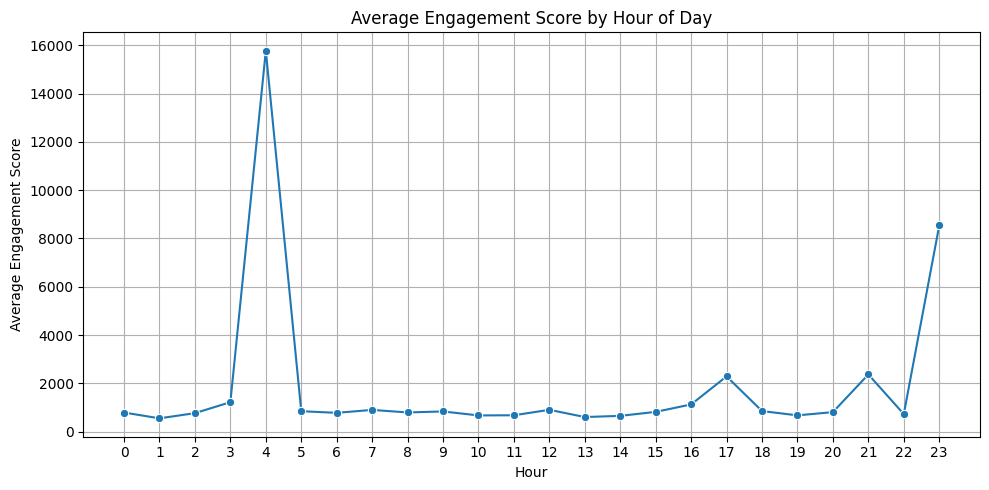

In [54]:
# Group and average engagement score by hour
hourly_engagement = df.groupby('hour')['engagement_score'].mean()

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=hourly_engagement.index, y=hourly_engagement.values, marker='o')
plt.title('Average Engagement Score by Hour of Day')
plt.xlabel('Hour')
plt.ylabel('Average Engagement Score')
plt.grid(True)
plt.xticks(range(0, 24))
plt.tight_layout()
plt.show()

#### 2. Engagement Score vs Year

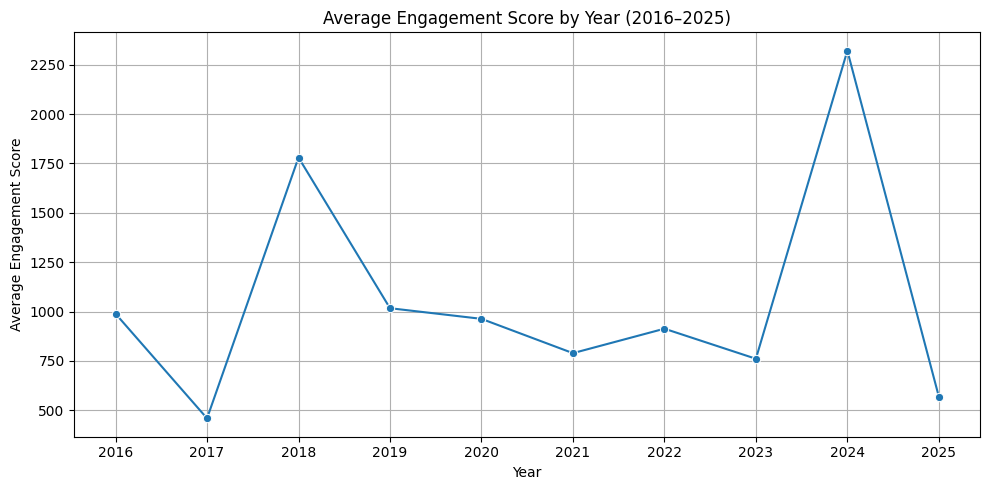

In [55]:
# Ensure 'year' column is numeric
df['year'] = pd.to_numeric(df['year'], errors='coerce')

# Filter for years 2020 to 2025
filtered_df = df[(df['year'] >= 2016) & (df['year'] <= 2025)]

# Group by year and calculate average retweets
yearly_engagement = filtered_df.groupby('year')['engagement_score'].mean()

# Plot
plt.figure(figsize=(10, 5))
sns.lineplot(x=yearly_engagement.index, y=yearly_engagement.values, marker='o')
plt.title('Average Engagement Score by Year (2016–2025)')
plt.xlabel('Year')
plt.ylabel('Average Engagement Score')
plt.grid(True)
plt.xticks(yearly_engagement.index)  # Set ticks to actual years in data
plt.tight_layout()
plt.show()


#### Engagement Score vs Holiday Name

- Do people engage more during specific holidays?

#### Hate speech counts per holiday:

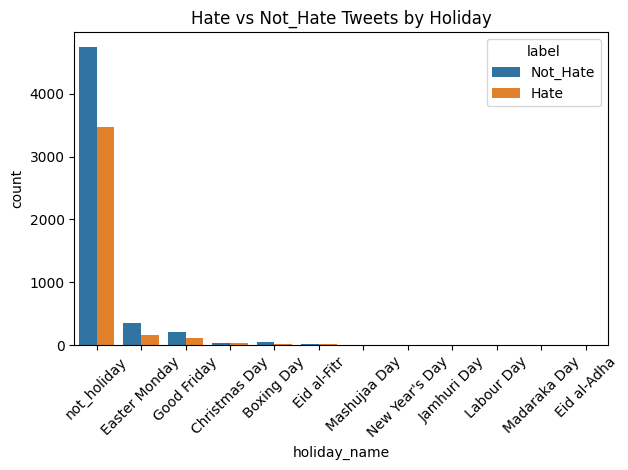

In [56]:
sns.countplot(data=df, x='holiday_name', hue='label')
plt.xticks(rotation=45)
plt.title('Hate vs Not_Hate Tweets by Holiday')
plt.tight_layout()
plt.show()

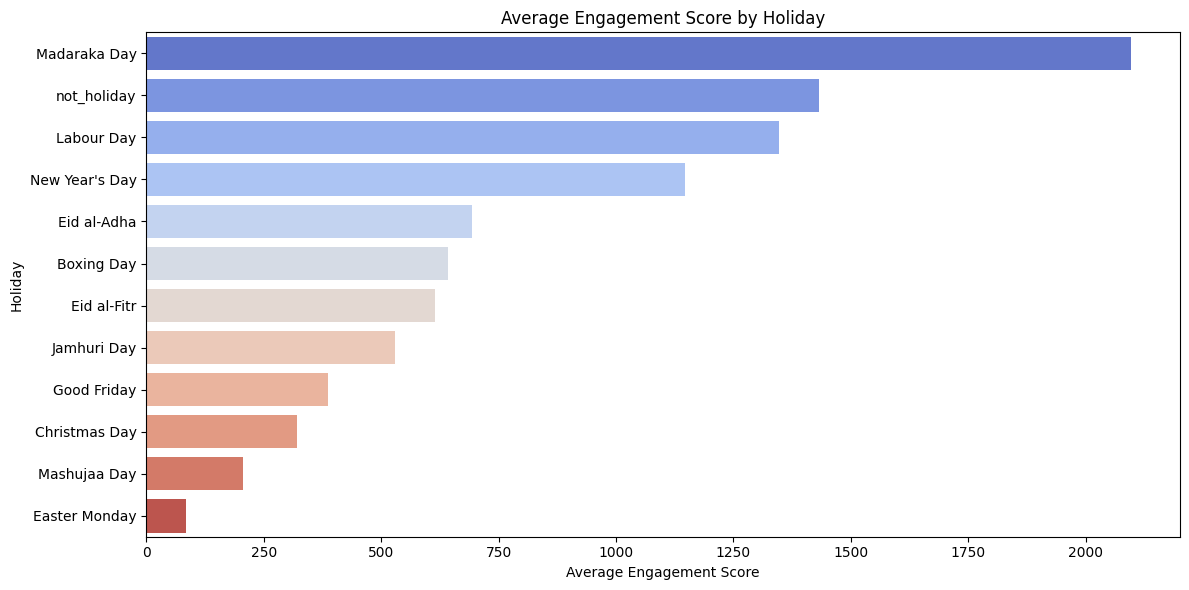

In [57]:
# Filter out non-holiday rows (if holidays are labeled as empty string or NaN)
#holiday_df = df[df['holiday_name'].notnull() & (df['holiday_name'] != '')]

# Group by holiday and calculate average engagement
holiday_engagement = df.groupby('holiday_name')['engagement_score'].mean().sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 6))
sns.barplot(x=holiday_engagement.values, y=holiday_engagement.index, palette='coolwarm')
plt.title('Average Engagement Score by Holiday')
plt.xlabel('Average Engagement Score')
plt.ylabel('Holiday')
plt.tight_layout()
plt.show()

### 3.3.3 Engagement Breakdown
**Likes / Retweets / Replies vs Label**

- Are negative tweets more likely to be retweeted?

- Do positive tweets get more likes?

- Are replies more common on neutral tweets?

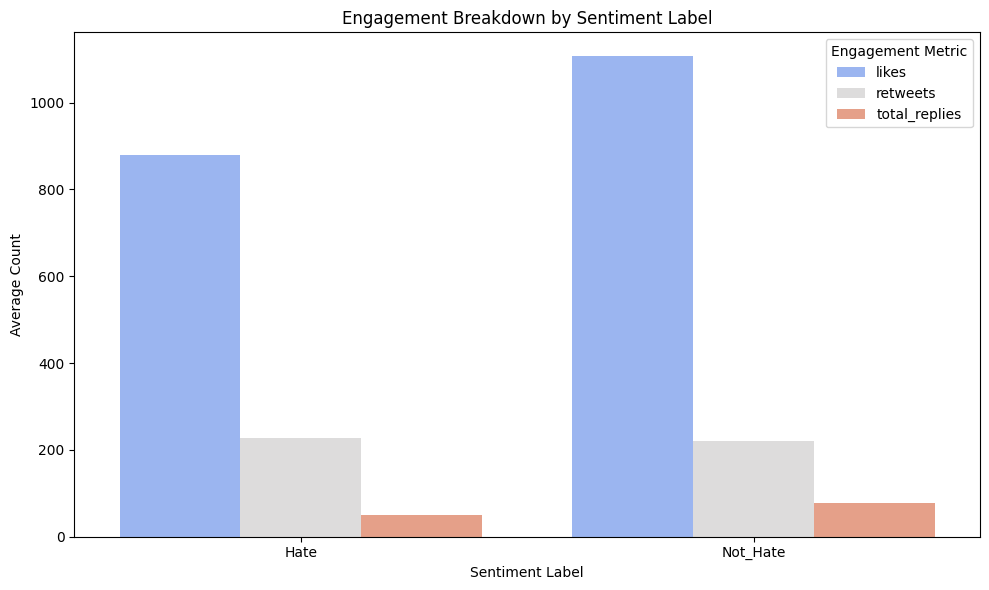

In [58]:
# Group by sentiment label and calculate average likes, retweets, and replies
engagement_metrics = df.groupby('label')[['likes', 'retweets', 'total_replies']].mean().reset_index()

# Melt for seaborn compatibility
engagement_melted = engagement_metrics.melt(id_vars='label', 
                                             value_vars=['likes', 'retweets', 'total_replies'],
                                             var_name='Metric', value_name='Average Count')

# Plot
plt.figure(figsize=(10, 6))
sns.barplot(data=engagement_melted, x='label', y='Average Count', hue='Metric', palette='coolwarm')
plt.title('Engagement Breakdown by Sentiment Label')
plt.xlabel('Sentiment Label')
plt.ylabel('Average Count')
plt.legend(title='Engagement Metric')
plt.tight_layout()
plt.show()

#### Likes / Retweets vs Time Features (hour, day, month)

Understand timing of virality.

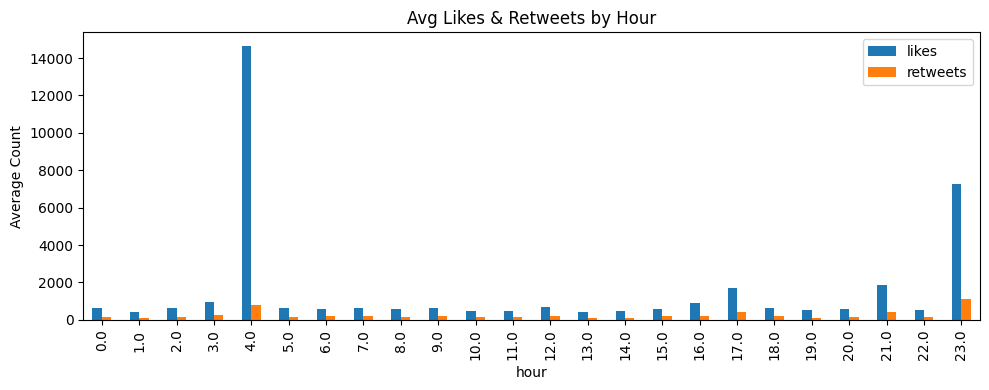

In [59]:
# Likes & Retweets by Hour
df.groupby('hour')[['likes', 'retweets']].mean().plot(kind='bar', figsize=(10, 4))
plt.title('Avg Likes & Retweets by Hour')
plt.ylabel('Average Count')
plt.tight_layout()
plt.show()

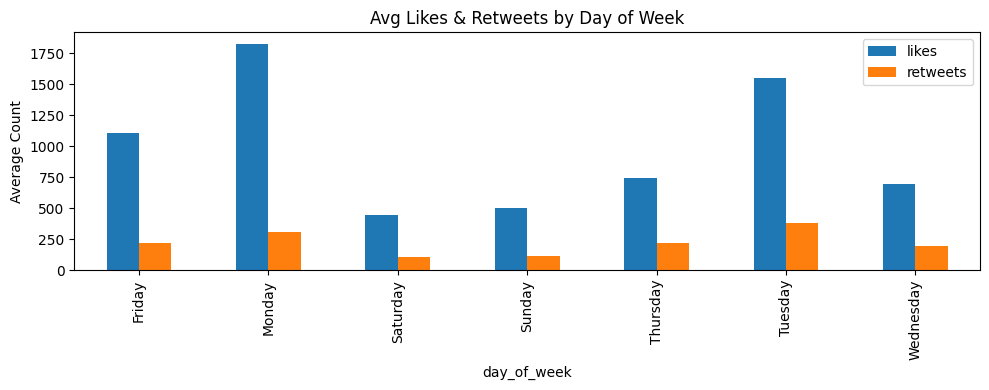

In [60]:
# Likes & Retweets by Day of Week
df.groupby('day_of_week')[['likes', 'retweets']].mean().plot(kind='bar', figsize=(10, 4))
plt.title('Avg Likes & Retweets by Day of Week')
plt.ylabel('Average Count')
plt.tight_layout()
plt.show()

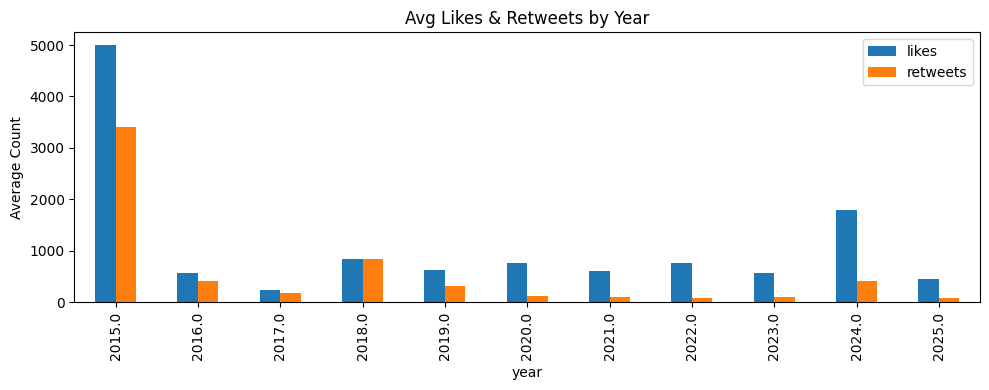

In [61]:
# Filter df to include only data from 2015 and beyond
df_filtered = df[df['year'] >= 2015]

# Group by year and calculate the mean for likes and retweets
df_filtered.groupby('year')[['likes', 'retweets']].mean().plot(kind='bar', figsize=(10, 4))

# Set plot title and labels
plt.title('Avg Likes & Retweets by Year')
plt.ylabel('Average Count')
plt.tight_layout()

# Show plot
plt.show()

### 3.3.4 Entity Involvement

#### Tweet Volume by Political Label

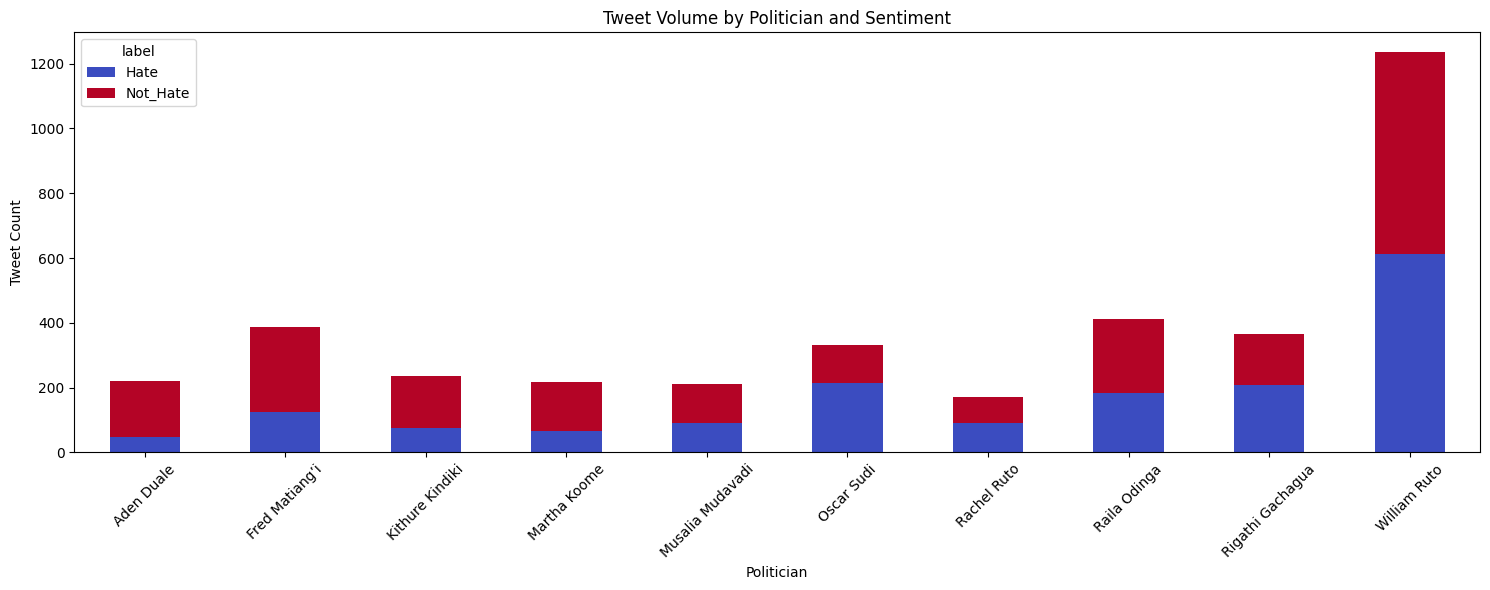

In [62]:
# Step 1: Explode the DataFrame and drop NaN rows in 'clean_names'
df_exploded = df.explode('clean_names')
df_exploded = df_exploded.dropna(subset=['clean_names'])

# Step 2: Filter out 'unknown' values from 'clean_names'
df_exploded = df_exploded[df_exploded['clean_names'] != 'unknown']

# Step 3: Count the most mentioned people/entities
top_10_politicians = df_exploded['clean_names'].value_counts().head(10).index.tolist()

# Step 4: Filter to only include rows where entity is one of the top 10
df_top = df_exploded[df_exploded['clean_names'].isin(top_10_politicians)]

# Step 5: Create pivot table grouped by person and sentiment label
pivot_df = df_top.groupby(['clean_names', 'label']).size().unstack(fill_value=0)

# Step 6: Plot
pivot_df.plot(kind='bar', stacked=True, figsize=(15,6), colormap='coolwarm')
plt.title('Tweet Volume by Politician and Sentiment')
plt.xlabel('Politician')
plt.ylabel('Tweet Count')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

#### Engagement Score vs Politician

Which politicians trigger more public interaction?

In [63]:
# Filter out 'unknown' from the top 50 names
top_50_names = df.sort_values('engagement_score', ascending=False).head(50)['clean_names'].tolist()
top_50_names = [name for name in top_50_names if name != 'unknown' and name != '']
print(top_50_names)

['William Ruto', 'William Ruto', 'Raila Odinga', 'William Ruto', 'Oscar Sudi', 'Kalonzo Musyoka', 'Oscar Sudi', 'Aden Duale', 'Oscar Sudi', 'Aden Duale', 'Martha Koome', 'William Ruto', 'William Ruto', 'Kithure Kindiki']


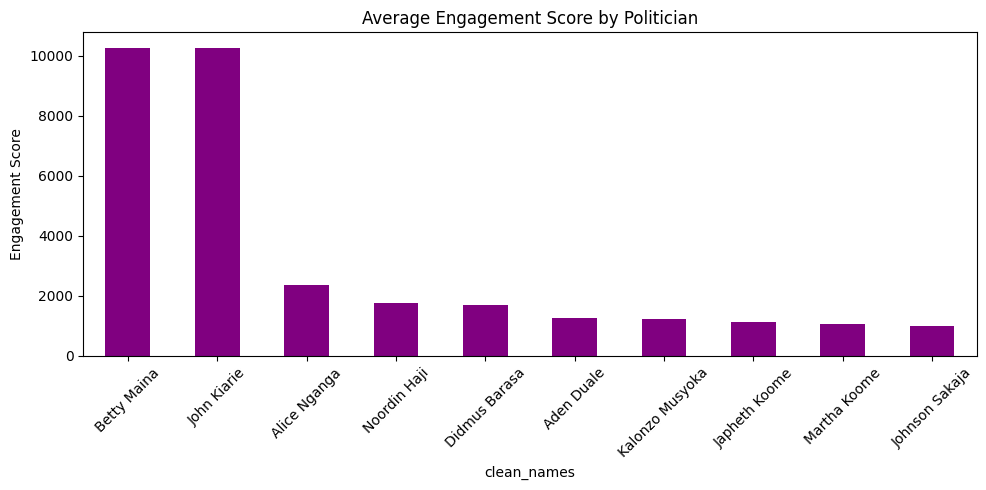

In [64]:
engagement_by_politician = (
    df[df['clean_names'] != 'unknown']  # Exclude 'unknown'
    .groupby('clean_names')['engagement_score']
    .mean()
    .sort_values(ascending=False)
    .head(10)
)

# Step 3: Plot the average engagement score by politician
engagement_by_politician.plot(kind='bar', figsize=(10, 5), color='purple')
plt.title('Average Engagement Score by Politician')
plt.ylabel('Engagement Score')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


### 4. Sentiment / Hate Label vs Time / Activity

#### Label vs Hour / Day / Month

When is hate speech most likely?

Plot: Heatmap

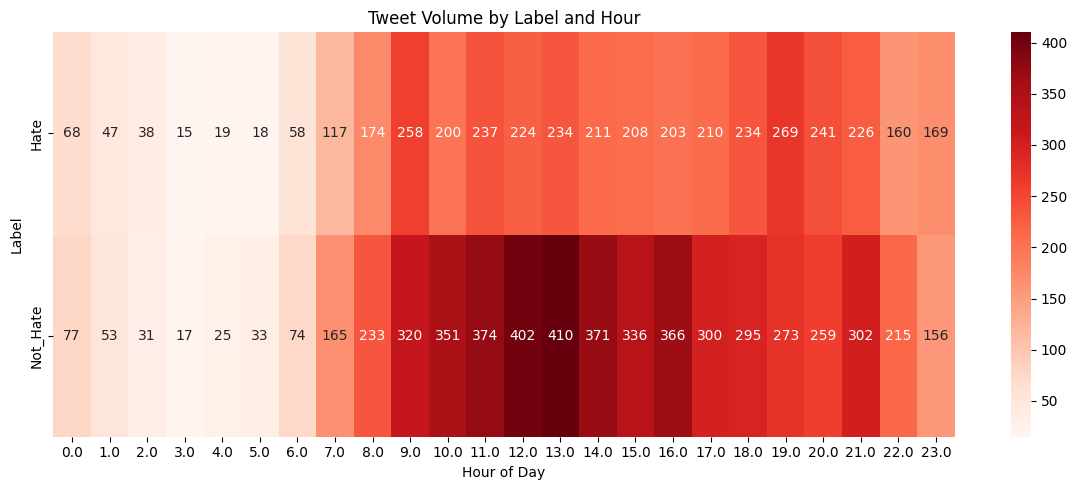

In [65]:
# Create a pivot table: count of tweets by label and hour
heatmap_data = df.pivot_table(index='label', columns='hour', values='cleaned_text', aggfunc='count', fill_value=0)

# Plot
plt.figure(figsize=(12, 5))
sns.heatmap(heatmap_data, cmap='Reds', annot=True, fmt='d')
plt.title('Tweet Volume by Label and Hour')
plt.xlabel('Hour of Day')
plt.ylabel('Label')
plt.tight_layout()
plt.show()

#### Label vs Holiday

Is hate speech more or less common on holidays?

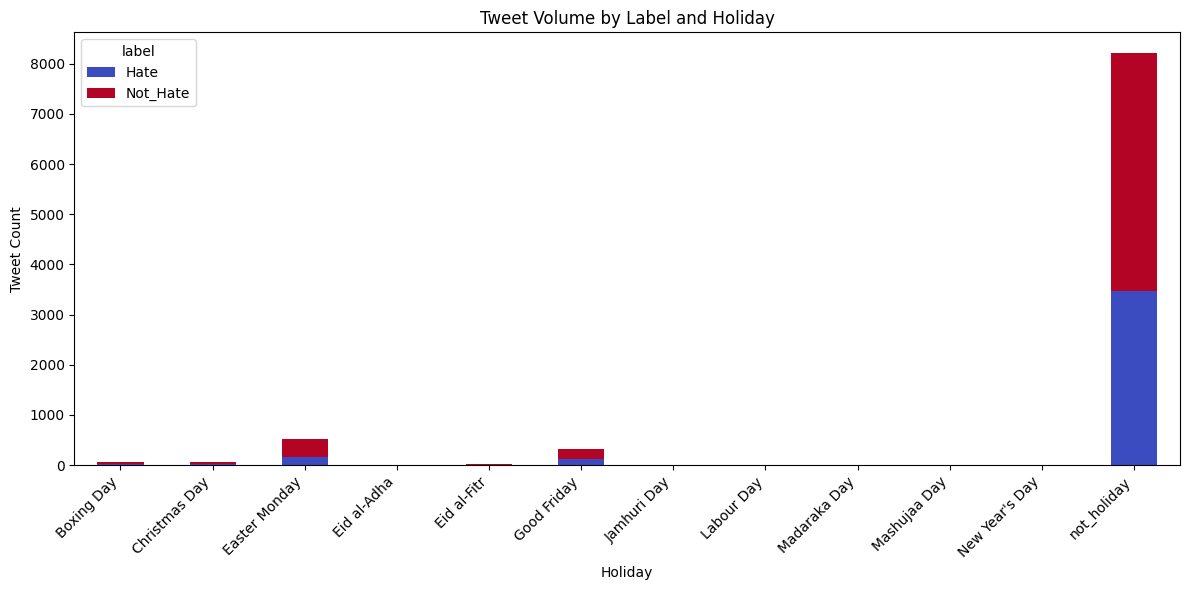

In [66]:
# Count tweets by label and holiday name
label_holiday_counts = df.groupby(['holiday_name', 'label']).size().unstack().fillna(0)

# Plot
label_holiday_counts.plot(kind='bar', stacked=True, figsize=(12, 6), colormap='coolwarm')
plt.title('Tweet Volume by Label and Holiday')
plt.xlabel('Holiday')
plt.ylabel('Tweet Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [67]:
df['label'].value_counts()

label
Not_Hate    5438
Hate        3838
Name: count, dtype: int64

In [68]:
df['label'].value_counts(normalize=True) * 100

label
Not_Hate    58.624407
Hate        41.375593
Name: proportion, dtype: float64

In [69]:
df.shape

(9276, 19)